# Problem Statement
With the Chest X - Ray dataset, Develop a Machine Learning Model to classify the X Rays of Healthy vs Pneumonia (Corona) affected patients & this model powers the AI application to test the Corona Virus in Faster Phase.

In [43]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from IPython.display import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Recall
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [4]:
data_summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
data_summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


## Data Exploration

In [5]:
df = pd.read_csv('Chest_xray_Corona_Metadata.csv')

In [6]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


No null value in 'X_ray_image_name' and 'Label' so no need to drop any data entries.

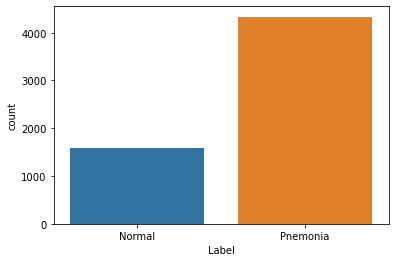

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [8]:
# checking unique Label values

sns.countplot(x = df['Label'])
plt.show()
df['Label'].value_counts()

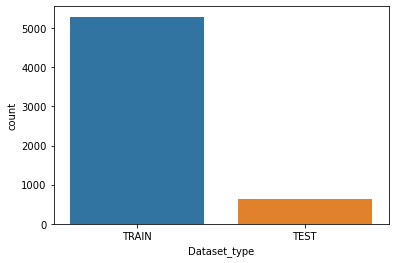

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [9]:
sns.countplot(x = df['Dataset_type'])
plt.show()
df['Dataset_type'].value_counts()

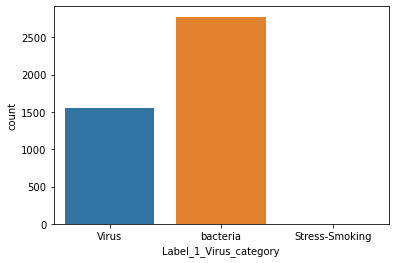

bacteria          2777
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [10]:
sns.countplot(x = df['Label_1_Virus_category'])
plt.show()
df['Label_1_Virus_category'].value_counts()

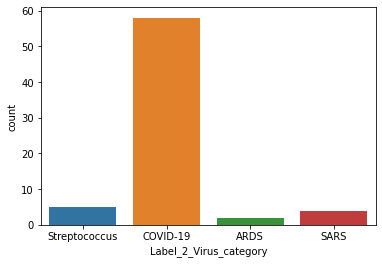

COVID-19         58
Streptococcus     5
SARS              4
ARDS              2
Name: Label_2_Virus_category, dtype: int64

In [11]:
sns.countplot(x = df['Label_2_Virus_category'])
plt.show()
df['Label_2_Virus_category'].value_counts()

In [12]:
# senity check for covid data
covid_df = df[df['Label_2_Virus_category'] == 'COVID-19']
covid_df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5221,5221,kjr-21-e25-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5222,5225,kjr-21-e24-g003-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5223,5228,kjr-21-e24-g002-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5224,5231,kjr-21-e24-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5225,5234,jkms-35-e79-g001-l-c.jpg,Pnemonia,TRAIN,COVID-19,Virus
5226,5235,jkms-35-e79-g001-l-b.jpg,Pnemonia,TRAIN,COVID-19,Virus
5227,5236,jkms-35-e79-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5228,5237,gr1_lrg-b.jpg,Pnemonia,TRAIN,COVID-19,Virus
5229,5238,gr1_lrg-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5230,5239,all14238-fig-0001-m-b.jpg,Pnemonia,TRAIN,COVID-19,Virus


Main objective is to distinguish CoVid from other Pnemonia for faster test for corona virus.
Modify datafram lable to clasify 3 different classes.

In [13]:
df.loc[df['Label_2_Virus_category'] == 'COVID-19', 'Label'] = 'COVID-19'

In [14]:
df['Label'].value_counts()

Pnemonia    4276
Normal      1576
COVID-19      58
Name: Label, dtype: int64

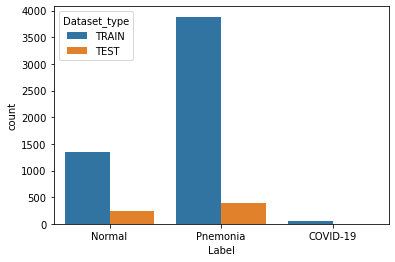

Pnemonia    4276
Normal      1576
COVID-19      58
Name: Label, dtype: int64

In [15]:
sns.countplot(x = df['Label'], hue = df['Dataset_type'])
plt.show()
df['Label'].value_counts()

CoVid data is very less compare to Pnemonia. Augmentation can increase covid data.
There is no covid class label in test set so we need to re-sample dataset

# Visualize image

In [16]:
img_path = './Dataset/'

./Dataset/IM-0128-0001.jpeg


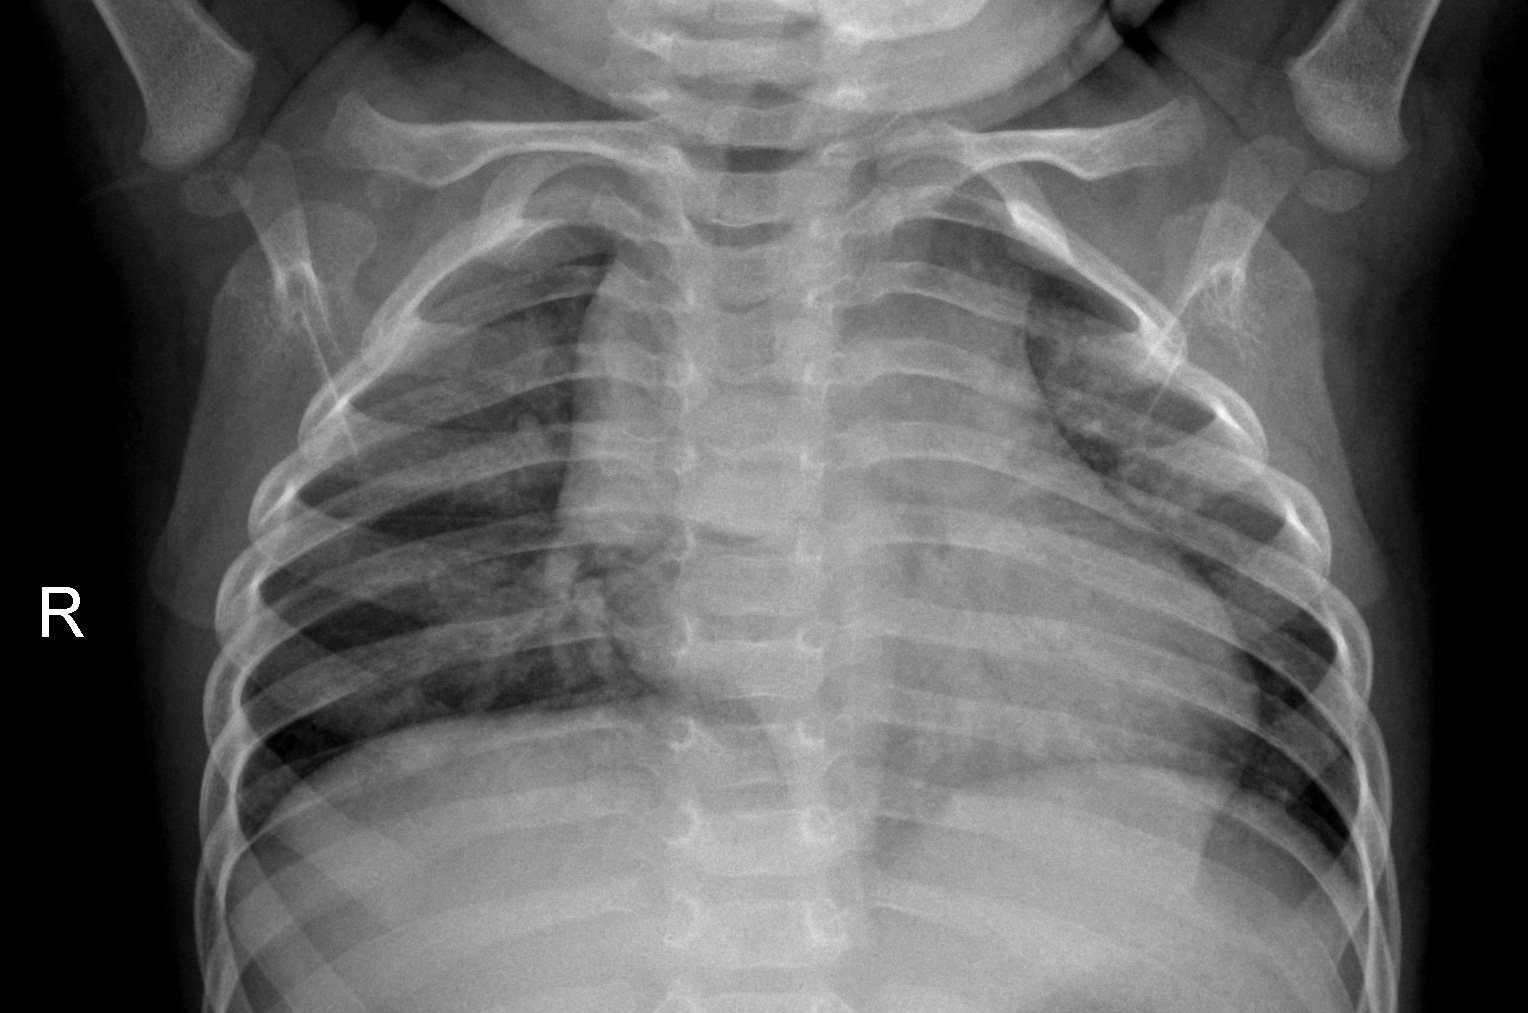

In [17]:
normal = img_path + df[df['Label'] == 'Normal'].iloc[0]['X_ray_image_name']
print(normal)
Image(filename=normal) 

./Dataset/person101_virus_188.jpeg


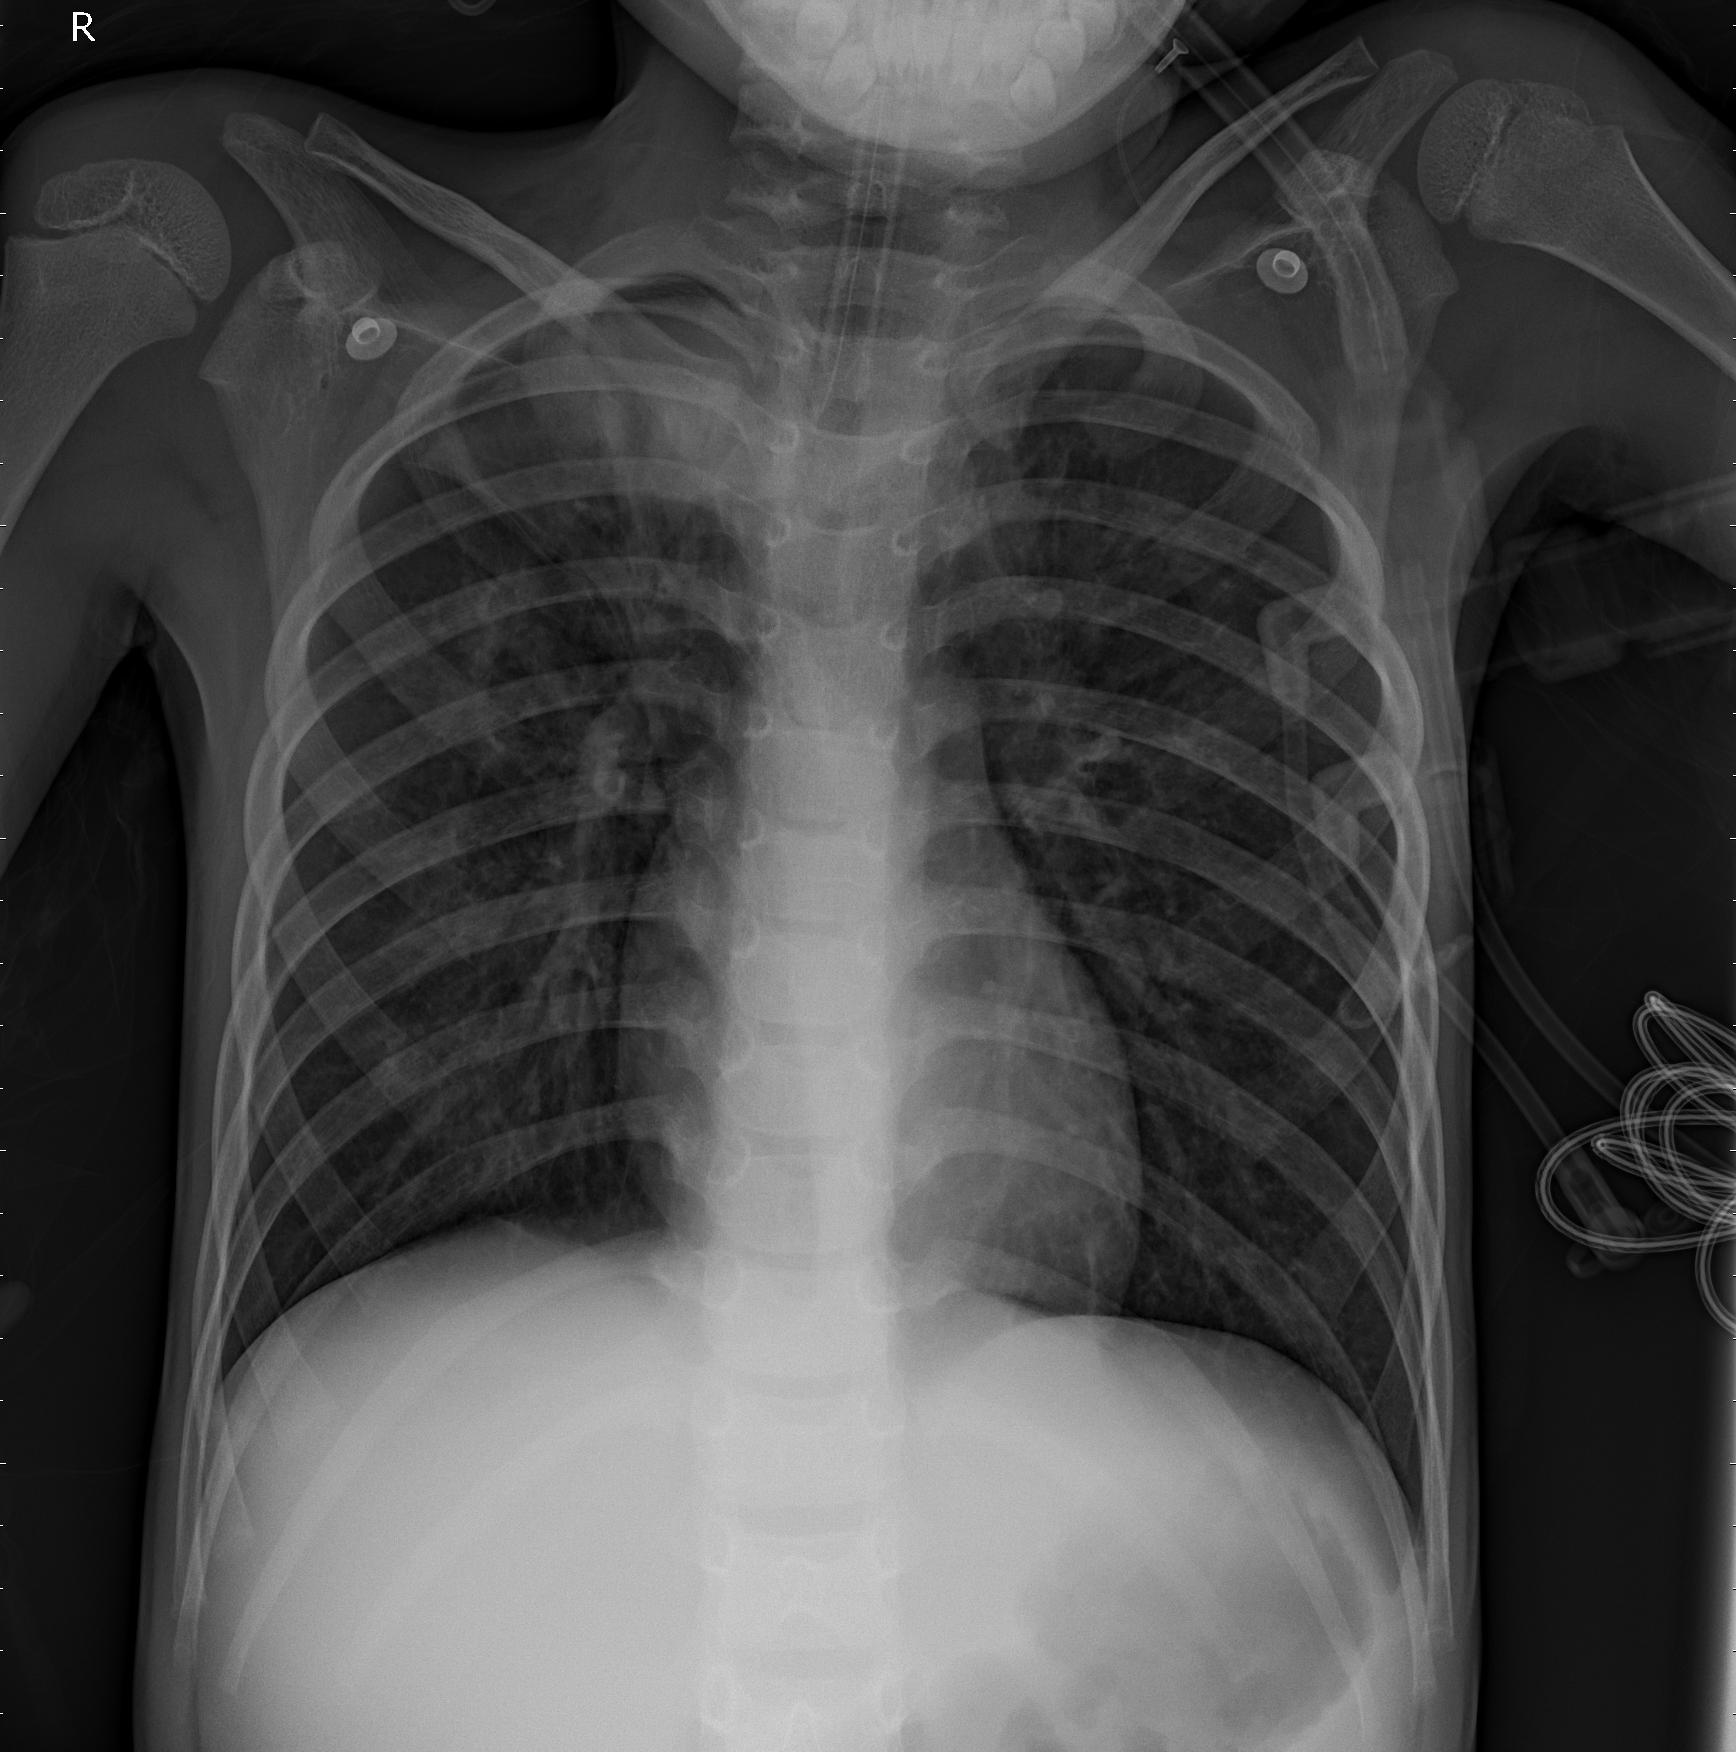

In [18]:
pnemonia = img_path + df[df['Label'] == 'Pnemonia'].iloc[0]['X_ray_image_name']
print(pnemonia)
Image(filename=pnemonia) 

./Dataset/kjr-21-e25-g001-l-a.jpg


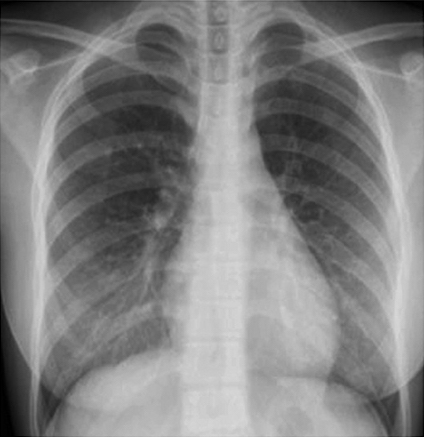

In [19]:
covid = img_path + df[df['Label'] == 'COVID-19'].iloc[0]['X_ray_image_name']
print(covid)
Image(filename=covid) 

# Data augmentation

In [20]:
# data generator
img_gen = ImageDataGenerator(rotation_range=10,brightness_range=(0.2, 1),horizontal_flip=True, zoom_range=[0.8, 1])

In [21]:
# split train and test data
train_test_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)

In [22]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 4519 to 3954
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              1182 non-null   int64 
 1   X_ray_image_name        1182 non-null   object
 2   Label                   1182 non-null   object
 3   Dataset_type            1182 non-null   object
 4   Label_2_Virus_category  11 non-null     object
 5   Label_1_Virus_category  883 non-null    object
dtypes: int64(1), object(5)
memory usage: 64.6+ KB


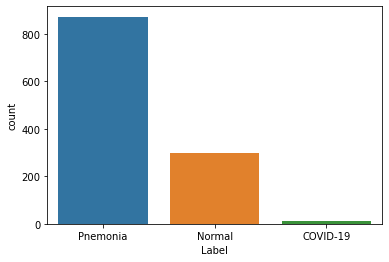

Pnemonia    873
Normal      299
COVID-19     10
Name: Label, dtype: int64

In [23]:
sns.countplot(x = valid_df['Label'])
plt.show()
valid_df['Label'].value_counts()

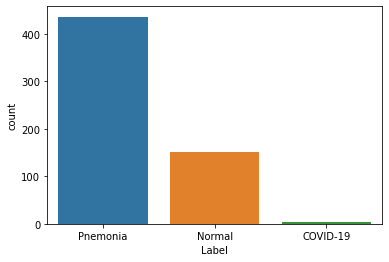

Pnemonia    436
Normal      152
COVID-19      3
Name: Label, dtype: int64

In [25]:
sns.countplot(x = test_df['Label'])
plt.show()
test_df['Label'].value_counts()

In [27]:
# create batches to train and validate model
train_batches = img_gen.flow_from_dataframe(train_df, directory='./Dataset', x_col='X_ray_image_name',
                                             y_col='Label', class_mode='categorical',batch_size=128)

valid_batches = img_gen.flow_from_dataframe(valid_df, directory='./Dataset', x_col='X_ray_image_name',
                                             y_col='Label', class_mode='categorical',batch_size=128)

test_batches = img_gen.flow_from_dataframe(test_df, directory='./Dataset', x_col='X_ray_image_name',
                                             y_col='Label', class_mode='categorical',batch_size=128)

Found 5319 validated image filenames belonging to 3 classes.
Found 1182 validated image filenames belonging to 3 classes.
Found 591 validated image filenames belonging to 3 classes.


In [28]:
# label index
print(train_batches.class_indices)

{'COVID-19': 0, 'Normal': 1, 'Pnemonia': 2}


## Model Building

In [29]:
# create directory to save models
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

In [31]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC'),
           Recall(name='Recall')]

In [33]:
# Resize image  
resize_and_rescale = Sequential([Resizing(227, 227),Rescaling(1./255)])

In [34]:
# builing Alexnet
lamb = 0.9

model = Sequential([
    # Preprocessing layer
    resize_and_rescale,
    
    InputLayer((227, 227, 3)),
    
    # 1st layer
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', kernel_regularizer=l2(lamb), name='conv1'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # 2nd layer
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # 3rd layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv3'),
    BatchNormalization(),
    
    # 4th layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv4'),
    BatchNormalization(),
    
    # 5th layer
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(lamb), name='conv5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    BatchNormalization(),
    
    # Flatten
    Flatten(),
    
    # 6th layer
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    
    # 7th layer
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    
    # 8th layer (output)
    Dense(units=3, activation='softmax')
], name='AlexNet')

In [29]:
#Create folder contains model's files
model_dir = 'models/alexnet'
model_file = 'best_alexnet.hdf5'
create_dir(model_dir)

checkpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), 
                              patience=7, min_delta=1e-3, verbose=1, min_lr=1e-7)

In [35]:
# train the model

batch_size = 128
epochs = 100

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=metrics)

history = model.fit(train_batches,epochs=epochs,verbose=1,validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),validation_steps=len(valid_batches))

Epoch 1/100
42/42 [==============================] - 735s 17s/step - loss: 491.4482 - TP: 2010.6047 - TN: 4846.3256 - FP: 774.4186 - FN: 799.7674 - AUC: 0.6906 - Recall: 0.6735 - val_loss: 9.8583 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.7135 - val_Recall: 0.7386
Epoch 2/100
42/42 [==============================] - 693s 16s/step - loss: 6.3454 - TP: 2198.0698 - TN: 5024.3953 - FP: 596.3488 - FN: 612.3023 - AUC: 0.8344 - Recall: 0.7774 - val_loss: 8.8788 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.6590 - val_Recall: 0.7386
Epoch 3/100
42/42 [==============================] - 691s 16s/step - loss: 6.1830 - TP: 2218.0233 - TN: 5000.7674 - FP: 551.0465 - FN: 557.8837 - AUC: 0.8587 - Recall: 0.7946 - val_loss: 2.2634 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.6670 - val_Recall: 0.7386
Epoch 4/100
42/42 [==============================] - 465s 11s/step -

42/42 [==============================] - 626s 15s/step - loss: 1.4356 - TP: 2273.8605 - TN: 5081.0698 - FP: 491.9535 - FN: 512.6512 - AUC: 0.8897 - Recall: 0.8183 - val_loss: 1.8365 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.7327 - val_Recall: 0.7386
Epoch 28/100
42/42 [==============================] - 678s 16s/step - loss: 1.4427 - TP: 2300.7209 - TN: 5100.6047 - FP: 453.8605 - FN: 476.5116 - AUC: 0.9016 - Recall: 0.8255 - val_loss: 1.8329 - val_TP: 904.0000 - val_TN: 2087.0000 - val_FP: 277.0000 - val_FN: 278.0000 - val_AUC: 0.8746 - val_Recall: 0.7648
Epoch 29/100
42/42 [==============================] - 665s 16s/step - loss: 1.6057 - TP: 2319.4651 - TN: 5147.5581 - FP: 467.8837 - FN: 488.2558 - AUC: 0.8969 - Recall: 0.8285 - val_loss: 1.6874 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.7157 - val_Recall: 0.7386
Epoch 30/100
42/42 [==============================] - 669s 16s/step - loss: 1.62

42/42 [==============================] - 331s 8s/step - loss: 2.1174 - TP: 2245.3953 - TN: 5045.9302 - FP: 484.6744 - FN: 519.9070 - AUC: 0.8913 - Recall: 0.8160 - val_loss: 1.7039 - val_TP: 876.0000 - val_TN: 2058.0000 - val_FP: 306.0000 - val_FN: 306.0000 - val_AUC: 0.8863 - val_Recall: 0.7411
Epoch 54/100
42/42 [==============================] - 330s 8s/step - loss: 1.6792 - TP: 2296.0000 - TN: 5121.5349 - FP: 483.3023 - FN: 506.4186 - AUC: 0.8964 - Recall: 0.8185 - val_loss: 1.8508 - val_TP: 873.0000 - val_TN: 2055.0000 - val_FP: 309.0000 - val_FN: 309.0000 - val_AUC: 0.6689 - val_Recall: 0.7386
Epoch 55/100
42/42 [==============================] - 333s 8s/step - loss: 2.2800 - TP: 2283.2558 - TN: 5124.0233 - FP: 496.7209 - FN: 527.1163 - AUC: 0.8755 - Recall: 0.8071 - val_loss: 2.4064 - val_TP: 872.0000 - val_TN: 2056.0000 - val_FP: 308.0000 - val_FN: 310.0000 - val_AUC: 0.7160 - val_Recall: 0.7377
Epoch 56/100
42/42 [==============================] - 329s 8s/step - loss: 2.0914 -

42/42 [==============================] - 330s 8s/step - loss: 1.8736 - TP: 2273.7209 - TN: 5076.2558 - FP: 467.6047 - FN: 498.2093 - AUC: 0.8970 - Recall: 0.8243 - val_loss: 2.3526 - val_TP: 915.0000 - val_TN: 2107.0000 - val_FP: 257.0000 - val_FN: 267.0000 - val_AUC: 0.8699 - val_Recall: 0.7741
Epoch 80/100
42/42 [==============================] - 331s 8s/step - loss: 1.9373 - TP: 2288.6279 - TN: 5082.7907 - FP: 453.1163 - FN: 479.3256 - AUC: 0.9095 - Recall: 0.8270 - val_loss: 2.3989 - val_TP: 904.0000 - val_TN: 2095.0000 - val_FP: 269.0000 - val_FN: 278.0000 - val_AUC: 0.8396 - val_Recall: 0.7648
Epoch 81/100
42/42 [==============================] - 330s 8s/step - loss: 1.6770 - TP: 2344.4419 - TN: 5140.8837 - FP: 413.5814 - FN: 432.7907 - AUC: 0.9204 - Recall: 0.8482 - val_loss: 1.5262 - val_TP: 875.0000 - val_TN: 2057.0000 - val_FP: 307.0000 - val_FN: 307.0000 - val_AUC: 0.7163 - val_Recall: 0.7403
Epoch 82/100
42/42 [==============================] - 329s 8s/step - loss: 1.6122 -

In [36]:
history_df = pd.DataFrame(history.history)

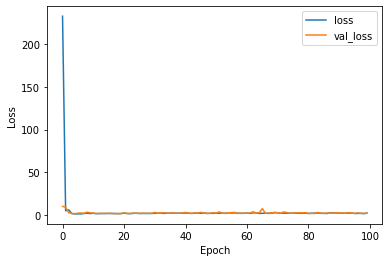

In [37]:
history_df[['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

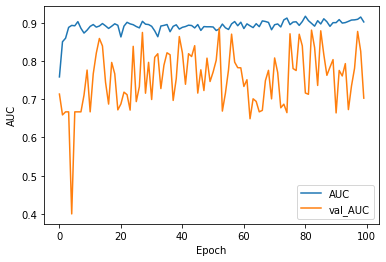

In [38]:
history_df[['AUC', 'val_AUC']].plot()
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

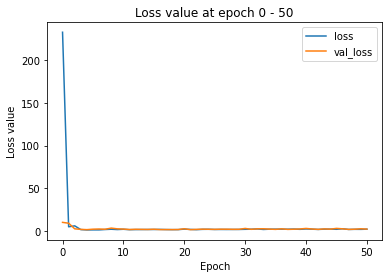

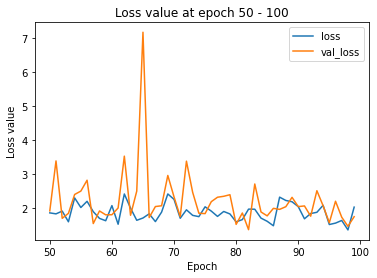

In [39]:
num_of_epochs = history_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_history = history_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_history = history_df.loc[half_epoch:len(history_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(history_df) }'

hists = [first_half_history, last_half_history]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

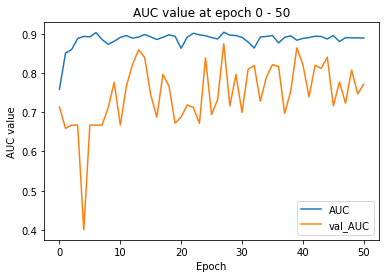

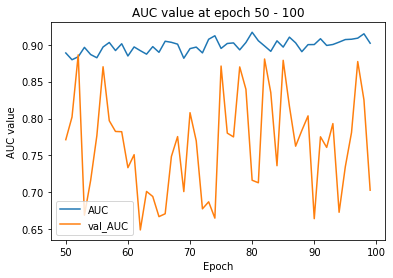

In [40]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(history_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

In [41]:
evaluate = model.evaluate(test_batches, verbose=1)

5/5 [==============================] - 46s 9s/step - loss: 1.7634 - TP: 435.0000 - TN: 1027.0000 - FP: 155.0000 - FN: 156.0000 - AUC: 0.6875 - Recall: 0.7360


In [42]:
loss, tp, fp, tn, fn, auc, recall = evaluate[0], evaluate[1], evaluate[2], evaluate[3], evaluate[4], evaluate[5], evaluate[6]
print('Test loss: ', loss)
print('True positive: ', tp)
print('False positive: ', fp)
print('True negative: ', tn)
print('False negative: ', fn)
print('AUC: ', auc)
print('Recall: ', recall)

Test loss:  1.7634209394454956
True positive:  435.0
False positive:  1027.0
True negative:  155.0
False negative:  156.0
AUC:  0.6874611973762512
Recall:  0.7360405921936035
